Perhaps Basset's most useful capability right now is to annotate noncoding genomic variants with their influence on functional properties like accessibility.

In a typical scenario, a researcher will be interested in a region that a GWAS has associated with a phenotype. In this region, there will be lead SNP that was measured in the study, and a set of nearby SNPs in linkage disequilibrium with it. A priori, the researcher cannot know which SNP(s) are truly associated with the phenotype.

The first and most important advice I can offer here is to make sure that Basset has been trained to predict relevant functional properties. Genome accessibility is a great choice because it captures a variety of regulatory events. However, you'll learn more about the SNP by training Basset on the most specific and relevant cell types that you can. See my preprocessing tutorials for advice on adding data to the ENCODE and Epigenomics Roadmap compendiums.

Here though, we'll just use the compendium. To run this tutorial, you'll need to either download the pre-trained model from https://www.dropbox.com/s/rguytuztemctkf8/pretrained_model.th.gz or substitute your own file here:

In [4]:
model_file = '../data/models/pretrained_model.th'

Using that trained model, *basset_sad.py* will compute SNP Accessibility Difference (SAD) profiles for a set of SNPs given in VCF format.

We'll demonstrate on an interesting SNP that I encountered in my explorations. The lead SNP [rs13336428 is associated with bone mineral density](http://www.ncbi.nlm.nih.gov/pubmed/22504420?dopt=Abstract). However, it's in linkage disequilibrium with rs67284550. I put both SNPs in *sad_eg/rs13336428.vcf*.

In [2]:
!cat sad_eg/rs13336428.vcf

chr16	1530949	rs67284550	C	T	Bone_mineral-rs13336428-A	0.131
chr16	1532463	rs13336428	G	A	Bone_mineral-rs13336428-A	0.822


Note that I've modified the VCF format here. The true format will still work fine. But, you can also borrow columns 6 and 7 to store some additional information about the SNP to aid downstream interpretation.

In column 6, I'm storing the lead index SNP, allowing you to group SNPs into their ambiguous haploblocks. Here, they both map to the lead SNP rs13336428 and reference its association to bone mineral density. But you can place lots of linked sets of SNPs into one file. Basset will process them all, but maintain their linkage in the table and plots.

In column 7, I'm storing a score associated with each SNP, that will be plotted next to it. Here, I've scored each SNP with its PICS probability of causality. [PICS uses fine mapping to model the GWAS signal with a better model](http://www.nature.com.ezp-prod1.hul.harvard.edu/nature/journal/v518/n7539/abs/nature13835.html). Thus, it's orthogonal to any functional analysis and useful as a barometer.

Then we run the script as follows:
* -l specifies the input sequence length, which for this model is 600 bp
* -i specifies that column 6 of the VCF has been co-opted to store the index SNP.
* -s specifies that column 7 of the VCF has been co-opted to store a score.
* -t specifies the target labels, which allows for more informative plots.

In [16]:
import subprocess

targets_file = 'sad_eg/sample_beds.txt'

cmd = 'basset_sad.py -l 600 -i -o sad -s -t %s %s sad_eg/rs13336428.vcf' % (targets_file, model_file)
subprocess.call(cmd, shell=True)

0

In the output directory, there will be a plot for every index SNP that shows the predicted accessibility across cell types, compared to the scores.

Here, we clearly see that rs13336428 has a far more substantial affect on accessibility than rs67284550.

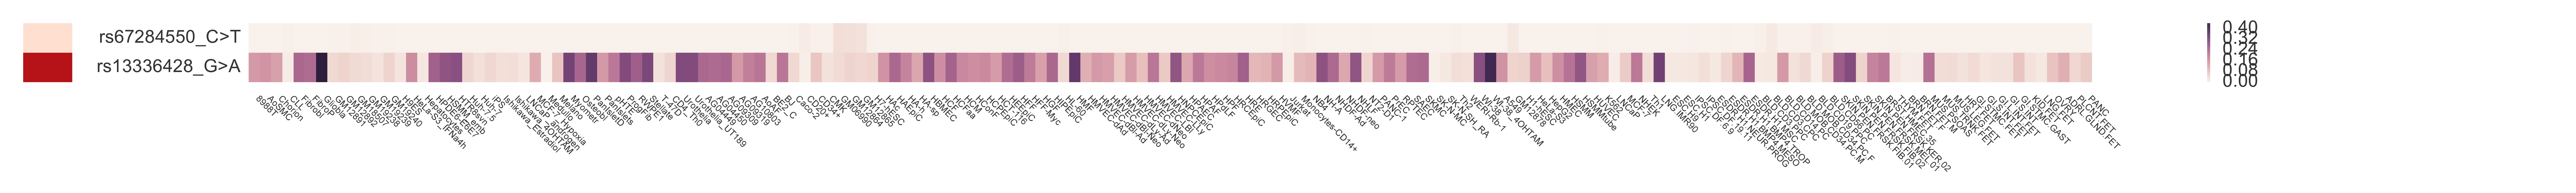

In [18]:
# actual file is sad/sad_Bone_mineral-rs13336428-A_heat.pdf

from IPython.display import Image
Image(filename='sad_eg/sad_Bone_mineral-rs13336428-A_heat.png')

There will also be a table with the following columns:

1. SNP RSID
2. Index SNP
3. Score
4. Reference allele
5. Alternative allele
6. Target
7. Reference prediction
8. Alternative prediction
9. SAD

This can help you zero in on the most affected targets.

In [19]:
! sort -k9 -g -r  sad/sad_table.txt | head

rs13336428    Bone_mineral-rs13336428-A 0.822      G      A   6 0.0918 0.5313  0.4396
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A 110 0.0568 0.4649  0.4081
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A  73 0.0396 0.3994  0.3598
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A  30 0.0741 0.4313  0.3572
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A 125 0.0346 0.3718  0.3372
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A  28 0.0781 0.4127  0.3345
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A  35 0.0638 0.3862  0.3224
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A  38 0.0680 0.3826  0.3146
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A  33 0.0984 0.4111  0.3127
rs13336428    Bone_mineral-rs13336428-A 0.822      G      A  39 0.0979 0.4101  0.3122


To better understand what the model is seeing in the region around these SNPs, we might also perform an in silico saturated mutagenesis.

Since we'd really like to see both alleles together, I wrote a modified version called *basset_sat_vcf.py* to which we can provide a VCF file as input.

In [22]:
cmd = 'basset_sat_vcf.py -t 6 -o sad/sat %s sad_eg/rs13336428.vcf' % model_file 
subprocess.call(cmd, shell=True)

0

With the G allele, we see potential, but no activity.

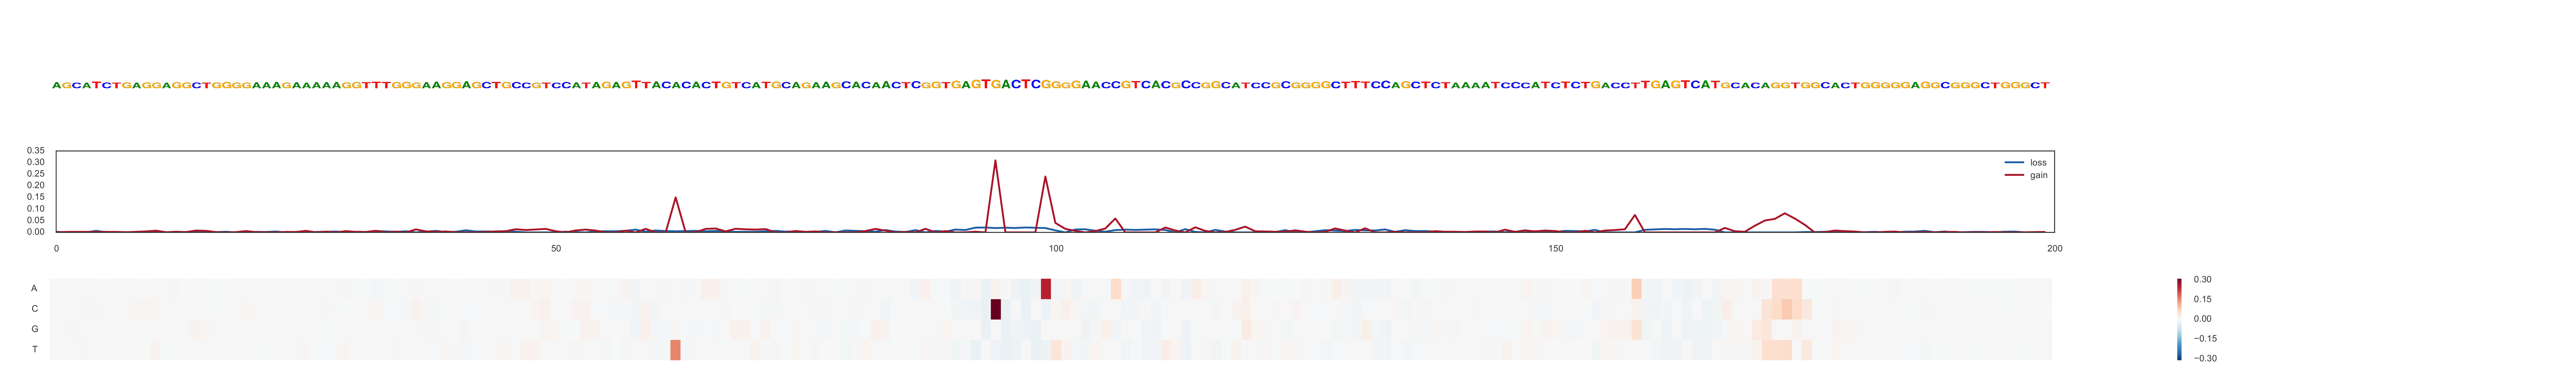

In [26]:
# actual file is sad/sat/rs13336428_G_c6_heat.pdf

Image(filename='sad_eg/rs13336428_G_c6_heat.png')

But mutated to an A, a binding site for the AP-1 complex emerges. Just to its right, a potential PAX family motif gains relevance. Further to the right, another AP-1 motif adds to the predicted accessibility.

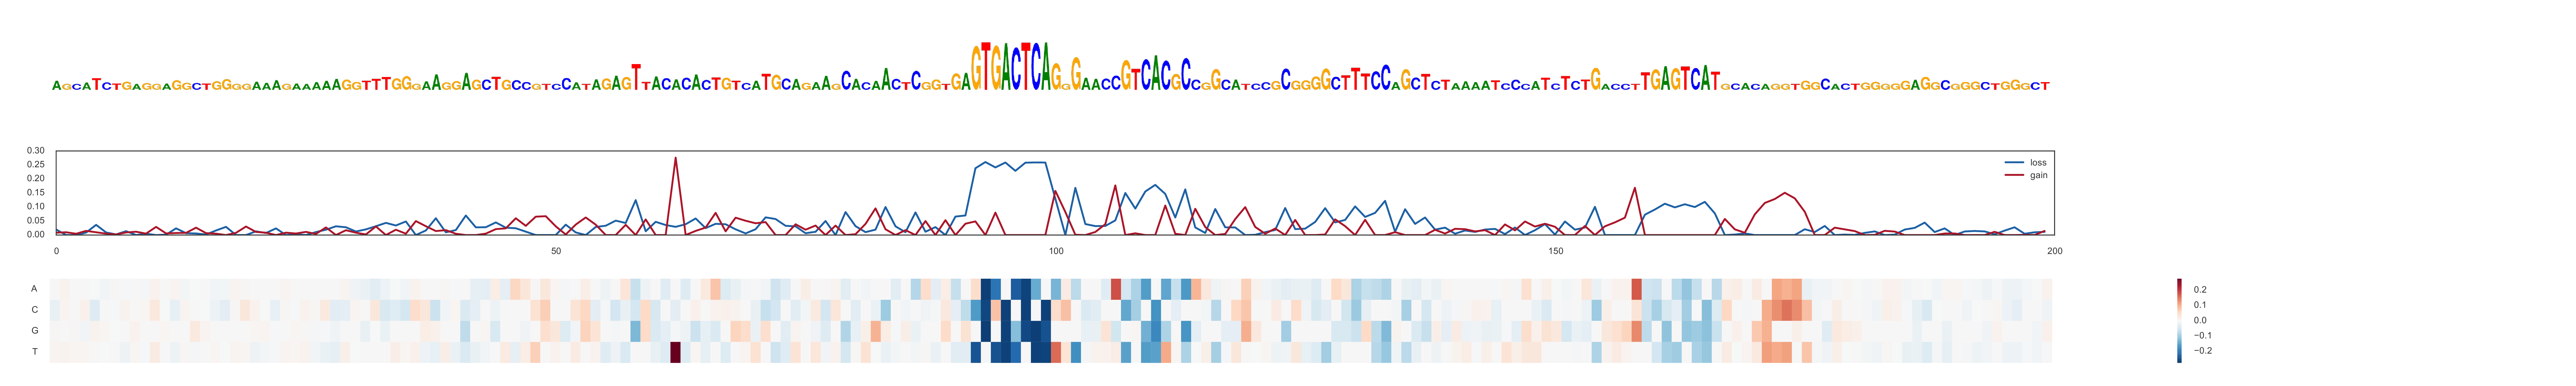

In [27]:
# actual file is sad/sat/rs13336428_A_c6_heat.pdf

Image(filename='sad_eg/rs13336428_A_c6_heat.png')

The mutation transform the regulatory potential of this site, and this analysis brings us one big step closer to figuring out how!